In [ ]:
import numpy as np
from tqdm import tqdm
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
import argparse
import time
import os
import re
import pandas as pd
from tensorflow.compat.v1.distributions import Bernoulli
import matplotlib.pyplot as plt
from tensorflow.compat.v1.train import RMSPropOptimizer
from scipy.sparse import save_npz, load_npz
from scipy.sparse import vstack, hstack

In [ ]:
def load_numpy(path, name):
    return load_npz(path+name).tocsr()

def load_pandas(path, name, row_name='userId', col_name='movieId',
                value_name='rating', shape=(138494, 131263), sep=','):
    df = pd.read_csv(path + name, sep=sep)
    rows = df[row_name]
    cols = df[col_name]
    if value_name is not None:
        values = df[value_name]
    else:
        values = [1]*len(rows)

    return csr_matrix((values, (rows, cols)), shape=shape)

def load_csv(path, name, shape=(1010000, 2262292)):
    data = np.genfromtxt(path + name, delimiter=',')
    matrix = csr_matrix((data[:, 2], (data[:, 0], data[:, 1])), shape=shape)
    save_npz(path + "rating.npz", matrix)
    return matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_path = '/content/drive/MyDrive/MASc_First_Year/CSC2515/CSC2515_Project_Part2/data/npz_files_threshold_4/'
hyperparameter_folder = '/content/drive/MyDrive/MASc_First_Year/CSC2515/CSC2515_Project_Part2/hyperparameter_tuning_thresholded/'
hyperparameter_file = 'hyperparams_tunning.csv'

In [ ]:
tuning_result = pd.read_csv(hyperparameter_folder + hyperparameter_file)
tuning_result = tuning_result[['corruption', 'rank', 'iter', 'lambda', 'NDCG@K', 'Recall@100', 'topK', 'weight_i', 'weight_u', 'Recall@50']]

In [ ]:
tuning_result

,corruption,rank,iter,lambda,NDCG@K,Recall@100,topK,weight_i,weight_u,Recall@50
0,0.2,50,200,0.00001,"[0.4818, 0.0144]",NaN,50,0.0,1.0,"[0.3313, 0.0145]"
1,0.2,50,200,0.00001,"[0.4773, 0.0144]",NaN,50,0.1,0.9,"[0.3382, 0.0148]"
2,0.2,50,200,0.00001,"[0.4676, 0.0146]",NaN,50,0.2,0.8,"[0.3295, 0.0148]"
3,0.2,50,200,0.00001,"[0.465, 0.0144]",NaN,50,0.3,0.7,"[0.3253, 0.0148]"
4,0.2,50,200,0.00001,"[0.4627, 0.0144]",NaN,50,0.4,0.6,"[0.3152, 0.0143]"
...,...,...,...,...,...,...,...,...,...,...
523,0.5,100,200,0.00100,"[0.4765, 0.0133]","[0.4541, 0.0163]",100,0.6,0.4,NaN
524,0.5,100,200,0.00100,"[0.4674, 0.0135]","[0.4318, 0.0161]",100,0.7,0.3,NaN
525,0.5,100,200,0.00100,"[0.4732, 0.0138]","[0.416, 0.0154]",100,0.8,0.2,NaN
526,0.5,100,200,0.00100,"[0.4638, 0.0139]","[0.3945, 0.0152]",100,0.9,0.1,NaN


In [ ]:
# Merging Recall@K columns
tuning_result['Recall@K'] = None
for recall_k in ['Recall@50', 'Recall@100']:
  tuning_result['Recall@K'] = tuning_result['Recall@50'].fillna(tuning_result[recall_k])

In [ ]:
# dropping other recall columns and the records with rank equal to 200
# df = tuning_result.drop(['Recall@50', 'Recall@100'], axis=1)

In [ ]:
max_recall_50 = max(tuning_result[tuning_result['topK'] == 50]['Recall@K'])
max_recall_100 = max(tuning_result[tuning_result['topK'] == 100]['Recall@K'])

In [ ]:
# Check maximum recall @ 100
tuning_result[(tuning_result['Recall@K']== max_recall_100)]

,corruption,rank,iter,lambda,NDCG@K,Recall@100,topK,weight_i,weight_u,Recall@50,Recall@K
452,0.2,100,200,0.001,"[0.4961, 0.0128]","[0.5156, 0.0172]",100,0.1,0.9,NaN,"[0.5156, 0.0172]"


In [ ]:
tuning_result[tuning_result['NDCG@K']== max(tuning_result['NDCG@K'])]

,corruption,rank,iter,lambda,NDCG@K,Recall@100,topK,weight_i,weight_u,Recall@50,Recall@K
451,0.2,100,200,0.001,"[0.5018, 0.0127]","[0.5117, 0.0165]",100,0.0,1.0,NaN,"[0.5117, 0.0165]"


In [ ]:
# Find same parameter for recall@ 50 
tuning_result[(tuning_result['corruption'] == 0.2) &
              (tuning_result['rank'] == 100) &
              (tuning_result['lambda'] == 0.001) &
              (tuning_result['topK'] == 50) &
              (tuning_result['weight_u'] == 1.0)]

,corruption,rank,iter,lambda,NDCG@K,Recall@100,topK,weight_i,weight_u,Recall@50,Recall@K
440,0.2,100,200,0.001,"[0.4934, 0.0143]",NaN,50,0.0,1.0,"[0.3484, 0.0149]","[0.3484, 0.0149]"


In [ ]:
best_hyper = (tuning_result[tuning_result['Recall@K']== max_recall_100]).to_dict('records')[0]

In [ ]:
best_hyper

{'NDCG@K': '[0.4961, 0.0128]',
 'Recall@100': '[0.5156, 0.0172]',
 'Recall@50': nan,
 'Recall@K': '[0.5156, 0.0172]',
 'corruption': 0.2,
 'iter': 200,
 'lambda': 0.001,
 'rank': 100,
 'topK': 100,
 'weight_i': 0.1,
 'weight_u': 0.9}

### plot for weight_u and weight_i

In [ ]:
import ast 

In [ ]:
df = tuning_result.copy()

In [ ]:
fixed_hyperparam = {'corruption': 0.2, 'iter': 200, 'lambda': 0.001, 'rank': 100, 'toK': 100}
prep_plot = df[(df['corruption'] == 0.2) & 
                (df['iter'] == 200) &
                (df['lambda'] == 0.001) &
                (df['rank'] == 100) & 
                (df['topK'] == 100)]

prep_plot['NDCG@K'] = prep_plot['NDCG@K'].apply(lambda x: ast.literal_eval(x))
prep_plot['Recall@K'] = prep_plot['Recall@K'].apply(lambda x: ast.literal_eval(x))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [ ]:
prep_plot

,corruption,rank,iter,lambda,NDCG@K,Recall@100,topK,weight_i,weight_u,Recall@50,Recall@K
451,0.2,100,200,0.001,"[0.5018, 0.0127]","[0.5117, 0.0165]",100,0.0,1.0,NaN,"[0.5117, 0.0165]"
452,0.2,100,200,0.001,"[0.4961, 0.0128]","[0.5156, 0.0172]",100,0.1,0.9,NaN,"[0.5156, 0.0172]"
453,0.2,100,200,0.001,"[0.4924, 0.0126]","[0.5071, 0.0172]",100,0.2,0.8,NaN,"[0.5071, 0.0172]"
454,0.2,100,200,0.001,"[0.4871, 0.0126]","[0.496, 0.0169]",100,0.3,0.7,NaN,"[0.496, 0.0169]"
455,0.2,100,200,0.001,"[0.4802, 0.0125]","[0.4826, 0.0166]",100,0.4,0.6,NaN,"[0.4826, 0.0166]"
456,0.2,100,200,0.001,"[0.4726, 0.0127]","[0.4613, 0.0162]",100,0.5,0.5,NaN,"[0.4613, 0.0162]"
457,0.2,100,200,0.001,"[0.4637, 0.0129]","[0.438, 0.016]",100,0.6,0.4,NaN,"[0.438, 0.016]"
458,0.2,100,200,0.001,"[0.4624, 0.013]","[0.423, 0.0156]",100,0.7,0.3,NaN,"[0.423, 0.0156]"
459,0.2,100,200,0.001,"[0.4561, 0.0134]","[0.396, 0.015]",100,0.8,0.2,NaN,"[0.396, 0.015]"
460,0.2,100,200,0.001,"[0.4545, 0.0138]","[0.3715, 0.0144]",100,0.9,0.1,NaN,"[0.3715, 0.0144]"


In [ ]:
x = np.array(prep_plot.weight_i)
y = np.array([result[0] for result in list(prep_plot['Recall@K'])])
ci = np.array([result[1] for result in list(prep_plot['Recall@K'])])

In [ ]:
y_ndcg = np.array([result[0] for result in list(prep_plot['NDCG@K'])])
ci_ndcg = np.array([result[1] for result in list(prep_plot['NDCG@K'])])

In [ ]:
best_x =  best_hyper['weight_i']
best_recallk = ast.literal_eval(best_hyper['Recall@K'])[0]
best_ndcg = ast.literal_eval(best_hyper['NDCG@K'])[0]

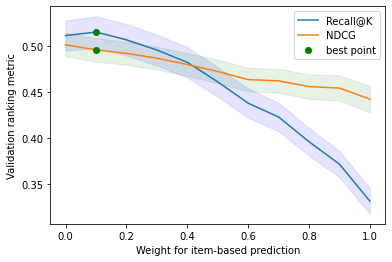

In [ ]:
#fig, ax = plt.subplots()
recall_line, = plt.plot(x,y, label='Recall@K')
ndcg_line, = plt.plot(x,y_ndcg, label='NDCG')
plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)
plt.fill_between(x, (y_ndcg-ci_ndcg), (y_ndcg+ci_ndcg), color='g', alpha=.1)
best_point, = plt.plot(best_x,best_recallk, 'o', color='green', label='best point')
plt.plot(best_x,best_ndcg, 'o', color='green')
plt.legend(handles=[recall_line, ndcg_line, best_point])
#plt.title("Metric Performance with incremental item-based prediction weight", fontsize=12)
plt.xlabel('Weight for item-based prediction') 
plt.ylabel('Validation ranking metric')
plt.show()